# 네이버 영화리뷰 감성 분석

## 0) Import

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Komoran

## 1) 데이터 불러오기

In [2]:
train = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [3]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (150000, 3) 
test shape => (50000, 3)


In [6]:
train.columns

Index(['id', 'document', 'label'], dtype='object')

## 2) 훈련 데이터 라벨링 값 비율 확인

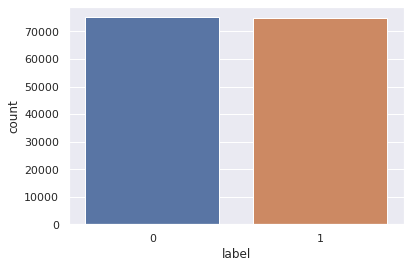

In [7]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

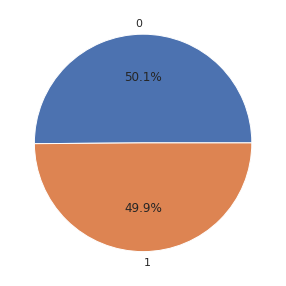

In [8]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3) 훈련, 테스트 데이터 결측치 값 확인

In [9]:
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [10]:
test.isnull().sum()

id          0
document    3
label       0
dtype: int64

## 4) 데이터 전처리
- 데이터 중복제거(drop_duplicates)  
- 결측치 제거(dropna)  
- 한국어 토크나이저를 활용한 토큰화(Komoran)  
- 불용어 제거(조사,구두점,접미사 종류)
- Bag of Words, word to index, index to word 구현  
- 문장 길이 분포와 적절 최대 문자 길이 지정  
- 최대 문자 길이에 따른 패딩 추가(pad_sequences)

In [13]:
from tqdm import tqdm, trange

In [14]:
tokenizer = Komoran()

def preprocess(train, test):
    train.drop_duplicates(subset=['document'], inplace=True)
    test.drop_duplicates(subset=['document'], inplace=True)
    train = train.dropna()
    test = test.dropna()
    print(f"train shape => {train.shape} \ntest shape => {test.shape}")
    
    train_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train['document']]
    test_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test['document']]
    
    exclusion_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC',
                      'SF', 'SP', 'SS', 'SE', 'SO', 'EF', 'EP', 'EC', 'ETN', 'ETM',
                      'XSN', 'XSV', 'XSA']
    
    f = lambda x: x in exclusion_tags
    
    X_train = []
    for i in trange(len(train_tokenized)):
        temp = []
        for j in range(len(train_tokenized[i])):
            if f(train_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_tokenized[i][j].split('/')[0])
        X_train.append(temp)
    
    X_test = []
    for i in trange(len(test_tokenized)):
        temp = []
        for j in range(len(test_tokenized[i])):
            if f(test_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_tokenized[i][j].split('/')[0])
        X_test.append(temp)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(30000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train['label'])), X_test, np.array(list(test['label'])), word_to_index

In [15]:
X_train, y_train, X_test, y_test, word_to_index = preprocess(train, test)

train shape => (146182, 3) 
test shape => (49157, 3)


100%|██████████| 49157/49157 [00:00<00:00, 64669.55it/s]


In [16]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [18]:
all_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in all_data]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 10.763011994532581
토큰 길이 최대: 140
토큰 길이 표준편차: 8.886926944778248
설정 최대 길이: 28
전체 문장의 0.9356554502685076%가 설정값인 28에 포함됩니다.


In [19]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=30)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=30)

In [20]:
print(f"X_train 1번째 값 길이 : {len(X_train[0])}\nX_test 1번째 값 길이 : {len(X_test[0])}")

X_train 1번째 값 길이 : 30
X_test 1번째 값 길이 : 30


# 모델 구성 및 validation set 구성

    모델 선정 이유
        - LSTM, Stacked LSTM, 1DConv
        - 일반적으로 자연어 분류 모델에서 자주 사용하는 모델들을 선정하였다 
    metrics 선정 이유
        - 데이터 label의 분포가 거의 1:1로 분포하여 accuracy를 사용하였다  
    loss 선정 이유
        - 이진 분류 문제이므로 binary cross entropy가 적절하다

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=777)

## 모델링 - LSTM

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [20]:
vocab_size = 10000
word_vector_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 3,009,897
Trainable params: 3,009,897
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[mc])

Epoch 1/10
3655/3655 [==============================] - 28s 6ms/step - loss: 0.3912 - accuracy: 0.8223 - val_loss: 0.3610 - val_accuracy: 0.8365

Epoch 00001: val_accuracy improved from -inf to 0.83647, saving model to lstm_best_model.h5
Epoch 2/10
3655/3655 [==============================] - 25s 7ms/step - loss: 0.3094 - accuracy: 0.8642 - val_loss: 0.3540 - val_accuracy: 0.8420

Epoch 00002: val_accuracy improved from 0.83647 to 0.84202, saving model to lstm_best_model.h5
Epoch 3/10
3655/3655 [==============================] - 24s 6ms/step - loss: 0.2650 - accuracy: 0.8868 - val_loss: 0.3728 - val_accuracy: 0.8385

Epoch 00003: val_accuracy did not improve from 0.84202
Epoch 4/10
3655/3655 [==============================] - 23s 6ms/step - loss: 0.2278 - accuracy: 0.9038 - val_loss: 0.3982 - val_accuracy: 0.8349

Epoch 00004: val_accuracy did not improve from 0.84202
Epoch 5/10
3655/3655 [==============================] - 21s 6ms/step - loss: 0.1980 - accuracy: 0.9182 - val_loss: 0.43

In [22]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.5996 - accuracy: 0.8217
[0.599583089351654, 0.8217141032218933]


In [52]:
def draw_graph(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [23]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


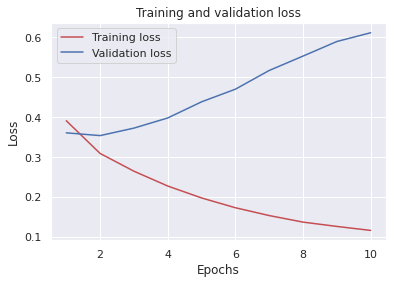

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 모델링 - Stacked LSTM

In [25]:
vocab_size = 10000
word_vector_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8, return_sequences = True))
model.add(tf.keras.layers.LSTM(units=16, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('stacked_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 8)           9888      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,011,505
Trainable params: 3,011,505
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 37s 9ms/step - loss: 0.3916 - accuracy: 0.8192 - val_loss: 0.3581 - val_accuracy: 0.8393

Epoch 00001: val_accuracy improved from -inf to 0.83935, saving model to stacked_lstm_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 33s 9ms/step - loss: 0.3065 - accuracy: 0.8661 - val_loss: 0.3553 - val_accuracy: 0.8393

Epoch 00002: val_accuracy did not improve from 0.83935
Epoch 3/20
3655/3655 [==============================] - 31s 8ms/step - loss: 0.2578 - accuracy: 0.8894 - val_loss: 0.3678 - val_accuracy: 0.8384

Epoch 00003: val_accuracy did not improve from 0.83935
Epoch 4/20
3655/3655 [==============================] - 31s 8ms/step - loss: 0.2167 - accuracy: 0.9094 - val_loss: 0.4093 - val_accuracy: 0.8362

Epoch 00004: val_accuracy did not improve from 0.83935
Epoch 5/20
3655/3655 [==============================] - 30s 8ms/step - loss: 0.1822 - accuracy: 0.9259 - val_loss: 0.4578 - val_accuracy: 0.8323

Epoch

In [27]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 5s 3ms/step - loss: 0.4502 - accuracy: 0.8349
[0.450198233127594, 0.8348760008811951]


In [28]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


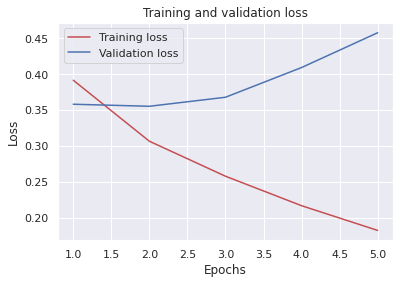

In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- overfitting ...

### 모델링 - CNN

In [30]:
embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.5 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

vocab_size = 10000
word_vector_dim = 300

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         196864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [31]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 22s 6ms/step - loss: 0.4096 - acc: 0.8114 - val_loss: 0.3612 - val_acc: 0.8361

Epoch 00001: val_acc improved from -inf to 0.83613, saving model to cnn_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 20s 5ms/step - loss: 0.3311 - acc: 0.8582 - val_loss: 0.3579 - val_acc: 0.8423

Epoch 00002: val_acc improved from 0.83613 to 0.84229, saving model to cnn_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 20s 5ms/step - loss: 0.2870 - acc: 0.8789 - val_loss: 0.3621 - val_acc: 0.8411

Epoch 00003: val_acc did not improve from 0.84229
Epoch 4/20
3655/3655 [==============================] - 19s 5ms/step - loss: 0.2541 - acc: 0.8939 - val_loss: 0.3816 - val_acc: 0.8406

Epoch 00004: val_acc did not improve from 0.84229
Epoch 5/20
3655/3655 [==============================] - 19s 5ms/step - loss: 0.2257 - acc: 0.9065 - val_loss: 0.3991 - val_acc: 0.8405

Epoch 00005: val_acc did not improve from 0.8

In [33]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


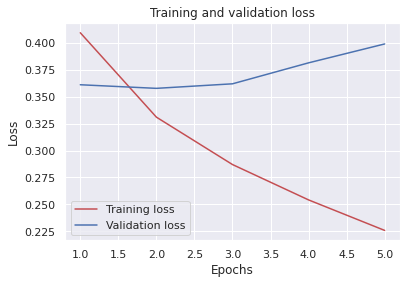

In [34]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
cnn_model = load_model('cnn_best_model.h5')
lstm_model = load_model('lstm_best_model.h5')
stacked_lstm_model = load_model('stacked_lstm_best_model.h5')

print("\ncnn 모델 테스트 정확도: %.4f" % (cnn_model.evaluate(X_test, y_test)[1]))
print("\nlstm 모델 테스트 정확도: %.4f" % (lstm_model.evaluate(X_test, y_test)[1]))
print("\nstacked lstm 모델 테스트 정확도: %.4f" % (stacked_lstm_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 4s 2ms/step - loss: 0.3575 - acc: 0.8410

cnn 모델 테스트 정확도: 0.8410
1537/1537 [==============================] - 5s 3ms/step - loss: 0.3551 - accuracy: 0.8422

lstm 모델 테스트 정확도: 0.8422
1537/1537 [==============================] - 6s 3ms/step - loss: 0.3578 - accuracy: 0.8409

stacked lstm 모델 테스트 정확도: 0.8409


## 학습된 Embedding 레이어 분석

In [22]:
from gensim.models import Word2Vec

In [37]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return list(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [48]:
tokenized_data = get_decoded_sentences(X_train, index_to_word)

In [51]:
tokens = []

for data in tokenized_data:
    data = [d for d in data if '<' not in d]
    tokens.append(data)

In [52]:
tokens 

[['영화', '자체', '멋지', '딴', '여자', '좋', '일', '한', '리즈', '미치', '불쌍'],
 ['너무', '기대', '크', '실망', '크', '법'],
 ['죽', '홍콩', '영화', '살', '있', '한류', '등'],
 ['짜증', '유발', '영화'],
 ['용인', '놈', '때문', '보', '재미없'],
 ['좀비', '영화', '매니아', '이', '보', '욕', '나오', '프랑스어', '더', '짜증', '배가'],
 ['위스키', '광고', '영상', '대놓고', '광고', '폭소', '만발'],
 ['네이버', '평점', '2', '배속', '관람', '가능', '하', '가끔', '고맙'],
 ['아', '레이첼', '웨이즈', '스릴러', '이렇', '로맨틱', '그리'],
 ['어린이', '어른', '세계', '대비', '말', '주', '의도', '멋지'],
 ['러시아', '1500', '만', '명', '관람', '전설', '이', '영화'],
 ['정말', '진심', '내', '인생', '최고'],
 ['말', '그대로', '하드코어'],
 ['어지럽', '디', '뻔', '3', 'd', '로보', '이', '토', '옮'],
 ['영화',
  '긴장감',
  '없',
  '재미',
  '없',
  '영화',
  '보',
  '욕',
  '처음',
  '이',
  '참',
  '류승범',
  '연기력',
  '있',
  '시나리오',
  '보',
  '눈',
  '없',
  '것',
  '같'],
 ['이스라엘', '땅', '회복', '!!!'],
 ['진짜', '재미없', '먼치킨', '전형'],
 ['앞',
  '삼',
  '형제',
  '스토리',
  '진행',
  '점점',
  '재밌',
  '지',
  '듯',
  '김재중',
  '연기',
  '좋',
  '비주얼',
  '좋',
  'ㅎㅎ'],
 ['조인성', '굿', '고현정', '굿', '지진희', '굿'],
 ['전혀', '느

In [53]:
embedding_dim = 100

model = Word2Vec(  
    sentences = tokens,
    window = 5,  
    min_count = 5,  
    workers = 4,  
    sg = 0  
)

In [54]:
print(model.wv.vectors.shape)

(11367, 100)


In [57]:
word_vectors = model.wv  
vocabs = list(word_vectors.key_to_index)

In [56]:
for sim_word in model.wv.most_similar("영화"):  
    print(sim_word)

('애니메이션', 0.6723892092704773)
('영화로', 0.6450902223587036)
('애니', 0.6066533923149109)
('작품', 0.5630531907081604)
('수작', 0.5370915532112122)
('대작', 0.509778618812561)
('재밌는 영화', 0.4875751733779907)
('명작', 0.4863019287586212)
('드라마', 0.4638851583003998)
('공포물', 0.46187692880630493)


## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [105]:
import os

In [106]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'

In [107]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [108]:
vector.shape

(100,)

In [109]:
word_vectors.wv.most_similar('영화')

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [110]:
vocab_size = 10000
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv.key_to_index:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [102]:
from tensorflow.keras.initializers import Constant

In [46]:
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         77056     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [47]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 17s 5ms/step - loss: 0.6055 - acc: 0.6566 - val_loss: 0.4572 - val_acc: 0.7868

Epoch 00001: val_acc improved from -inf to 0.78678, saving model to embedding_cnn_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 17s 5ms/step - loss: 0.4767 - acc: 0.7776 - val_loss: 0.4037 - val_acc: 0.8134

Epoch 00002: val_acc improved from 0.78678 to 0.81339, saving model to embedding_cnn_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 16s 4ms/step - loss: 0.4330 - acc: 0.8056 - val_loss: 0.3897 - val_acc: 0.8178

Epoch 00003: val_acc improved from 0.81339 to 0.81777, saving model to embedding_cnn_best_model.h5
Epoch 4/20
3655/3655 [==============================] - 17s 5ms/step - loss: 0.4127 - acc: 0.8176 - val_loss: 0.3769 - val_acc: 0.8287

Epoch 00004: val_acc improved from 0.81777 to 0.82868, saving model to embedding_cnn_best_model.h5
Epoch 5/20
3655/3655 [==============================] - 17s 5ms

In [48]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


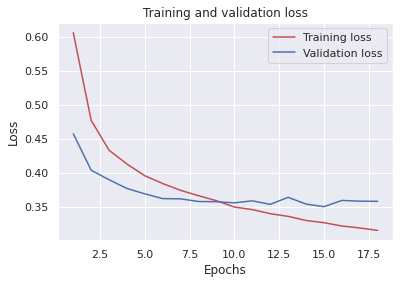

In [49]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [53]:
embedding_cnn_model = load_model('embedding_cnn_best_model.h5')

print("\nWord2vec 임베딩 후 cnn 모델 테스트 정확도: %.4f" % (embedding_cnn_model .evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3535 - acc: 0.8475

Word2vec 임베딩 후 cnn 모델 테스트 정확도: 0.8475


### lstm 모델 (Trainable True)

In [60]:
from keras.models import Sequential
from keras.layers import *

In [56]:
vocab_size = 10000
word_vector_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,003,497
Trainable params: 1,003,497
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/10
3655/3655 [==============================] - 24s 6ms/step - loss: 0.4496 - accuracy: 0.7852 - val_loss: 0.3944 - val_accuracy: 0.8200

Epoch 00001: val_accuracy improved from -inf to 0.82002, saving model to embedding_lstm_best_model.h5
Epoch 2/10
3655/3655 [==============================] - 21s 6ms/step - loss: 0.3599 - accuracy: 0.8413 - val_loss: 0.3816 - val_accuracy: 0.8297

Epoch 00002: val_accuracy improved from 0.82002 to 0.82970, saving model to embedding_lstm_best_model.h5
Epoch 3/10
3655/3655 [==============================] - 21s 6ms/step - loss: 0.3305 - accuracy: 0.8574 - val_loss: 0.3780 - val_accuracy: 0.8322

Epoch 00003: val_accuracy improved from 0.82970 to 0.83216, saving model to embedding_lstm_best_model.h5
Epoch 4/10
3655/3655 [==============================] - 21s 6ms/step - loss: 0.3097 - accuracy: 0.8674 - val_loss: 0.3803 - val_accuracy: 0.8350

Epoch 00004: val_accuracy improved from 0.83216 to 0.83504, saving model to embedding_lstm_best_model.h5

In [58]:
predict = model.evaluate(X_test, y_test, verbose=1)
print("\nWord2vec 임베딩 후 lstm 모델 테스트 정확도: %.4f" % (predict[1]))

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3917 - accuracy: 0.8328

Word2vec 임베딩 후 lstm 모델 테스트 정확도: 0.8328


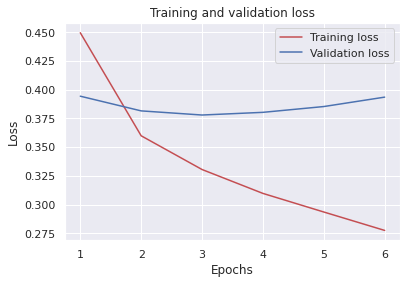

In [59]:
draw_graph(history)

## lstm (trainable=False)

In [62]:
vocab_size = 10000
word_vector_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=False))
model.add(tf.keras.layers.LSTM(units=10))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_lstm_tr_false.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 1,004,451
Trainable params: 4,451
Non-trainable params: 1,000,000
_________________________________________________________________


In [63]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/10
3655/3655 [==============================] - 19s 5ms/step - loss: 0.5014 - accuracy: 0.7521 - val_loss: 0.4781 - val_accuracy: 0.7675

Epoch 00001: val_accuracy improved from -inf to 0.76749, saving model to embedding_lstm_tr_false.h5
Epoch 2/10
3655/3655 [==============================] - 17s 5ms/step - loss: 0.4401 - accuracy: 0.7942 - val_loss: 0.4388 - val_accuracy: 0.7954

Epoch 00002: val_accuracy improved from 0.76749 to 0.79540, saving model to embedding_lstm_tr_false.h5
Epoch 3/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.4229 - accuracy: 0.8051 - val_loss: 0.4345 - val_accuracy: 0.7983

Epoch 00003: val_accuracy improved from 0.79540 to 0.79827, saving model to embedding_lstm_tr_false.h5
Epoch 4/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.4121 - accuracy: 0.8116 - val_loss: 0.4283 - val_accuracy: 0.8018

Epoch 00004: val_accuracy improved from 0.79827 to 0.80183, saving model to embedding_lstm_tr_false.h5
Epoch 5

In [64]:
predict = model.evaluate(X_test, y_test, verbose=1)
print("\nWord2vec 임베딩 후 lstm 모델 테스트 정확도: %.4f" % (predict[1]))

1537/1537 [==============================] - 4s 3ms/step - loss: 0.4114 - accuracy: 0.8138

Word2vec 임베딩 후 lstm 모델 테스트 정확도: 0.8138


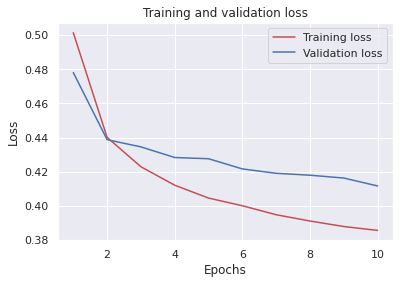

In [66]:
draw_graph(history)

### Stacked LSTM

In [68]:
vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(Embedding(vocab_size, word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   trainable=True))
model.add(tf.keras.layers.LSTM(units=8, return_sequences = True))
model.add(tf.keras.layers.LSTM(units=16, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('embedding_stacked_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 8)           3488      
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 1,005,105
Trainable params: 1,005,105
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3655/3655 [==============================] - 31s 8ms/step - loss: 0.4380 - accuracy: 0.7914 - val_loss: 0.3868 - val_accuracy: 0.8242

Epoch 00001: val_accuracy improved from -inf to 0.82423, saving model to embedding_stacked_lstm_best_model.h5
Epoch 2/20
3655/3655 [==============================] - 30s 8ms/step - loss: 0.3513 - accuracy: 0.8455 - val_loss: 0.3753 - val_accuracy: 0.8298

Epoch 00002: val_accuracy improved from 0.82423 to 0.82980, saving model to embedding_stacked_lstm_best_model.h5
Epoch 3/20
3655/3655 [==============================] - 31s 8ms/step - loss: 0.3248 - accuracy: 0.8598 - val_loss: 0.3718 - val_accuracy: 0.8351

Epoch 00003: val_accuracy improved from 0.82980 to 0.83511, saving model to embedding_stacked_lstm_best_model.h5
Epoch 4/20
3655/3655 [==============================] - 30s 8ms/step - loss: 0.3054 - accuracy: 0.8695 - val_loss: 0.3696 - val_accuracy: 0.8358

Epoch 00004: val_accuracy improved from 0.83511 to 0.83579, saving model to embe

In [71]:
predict = model.evaluate(X_test, y_test, verbose=1)
print("\nWord2vec 임베딩 후 Stacked LSTM 모델 테스트 정확도: %.4f" % (predict[1]))

1537/1537 [==============================] - 5s 3ms/step - loss: 0.3867 - accuracy: 0.8369

Word2vec 임베딩 후 Stacked LSTM 모델 테스트 정확도: 0.8369


# 전처리부터 다시
- 성능 개선을 위해 전처리부터 다시 진행하였다

In [73]:
from tqdm import tqdm, trange

In [72]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

In [74]:
train.drop_duplicates(subset=['document'], inplace=True)
test.drop_duplicates(subset=['document'], inplace=True)
train = train.dropna()
test = test.dropna()
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (143620, 3) 
test shape => (48389, 3)


In [75]:
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['document'] = train['document'].str.replace('^ +', "")
train['document'].replace('', np.nan, inplace=True)

/tmp/ipykernel_31/892576403.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_31/892576403.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace('^ +', "")


In [76]:
train.dropna(how = 'any', inplace=True)

In [77]:
print(train.shape)

(143620, 3)


In [78]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','을','으로','자','에','와','한','하다','하']

okt = Okt()

X_train = []
for sentence in tqdm(train['document']):
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

100%|██████████| 143620/143620 [10:51<00:00, 220.37it/s]


In [79]:
def preprocessing(test_data):
    test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
    test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
    test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
    test_data = test_data.dropna(how='any') # Null 값 제거
    print('전처리 후 테스트용 샘플의 개수 :',len(test_data))
    
    X_test = []
    for sentence in tqdm(test['document']):
        temp_X = okt.morphs(sentence, stem=True) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    return X_test, test_data

In [80]:
X_test, test_data = preprocessing(test)

/tmp/ipykernel_31/2793798119.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_31/2793798119.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


전처리 후 테스트용 샘플의 개수 : 48389


100%|██████████| 48389/48389 [03:49<00:00, 210.60it/s]


In [81]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'영화': 1, '보다': 2, '없다': 3, '이다': 4, '있다': 5, '좋다': 6, '너무': 7, '다': 8, '정말': 9, '되다': 10, '적': 11, '만': 12, '재밌다': 13, '같다': 14, '진짜': 15, '로': 16, '아니다': 17, '않다': 18, '점': 19, '에서': 20, '만들다': 21, '나오다': 22, '연기': 23, '것': 24, '평점': 25, '내': 26, '최고': 27, '그': 28, '나': 29, '안': 30, '인': 31, '스토리': 32, '생각': 33, '못': 34, '왜': 35, '드라마': 36, '게': 37, '사람': 38, '감동': 39, '보고': 40, '이렇다': 41, '고': 42, '말': 43, '아깝다': 44, '더': 45, '배우': 46, '때': 47, 'ㅋㅋ': 48, '아': 49, '감독': 50, '거': 51, '그냥': 52, '요': 53, '재미있다': 54, '재미': 55, '시간': 56, '내용': 57, '까지': 58, '뭐': 59, '중': 60, '주다': 61, '자다': 62, '하고': 63, '지루하다': 64, '수': 65, '재미없다': 66, '네': 67, '쓰레기': 68, '모르다': 69, '가다': 70, '들다': 71, '그렇다': 72, '싶다': 73, '지': 74, '작품': 75, '사랑': 76, '알다': 77, '하나': 78, '다시': 79, '마지막': 80, '볼': 81, '정도': 82, '저': 83, '이건': 84, '오다': 85, '완전': 86, 'ㅋ': 87, 'ㅠㅠ': 88, '많다': 89, '처음': 90, 'ㅋㅋㅋ': 91, '장면': 92, '액션': 93, '주인공': 94, '이렇게': 95, '안되다': 96, '걸': 97, '차다': 98, '나다': 99, '개': 100, '돈': 101, '이야기':

In [82]:
# 등장 빈도수가 3회 미만인 단어들의 분포 확인

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43750
등장 빈도가 2번 이하인 희귀 단어의 수: 24340
단어 집합에서 희귀 단어의 비율: 55.63428571428572
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9061418357453477


In [83]:
# 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19411


In [84]:
# 이를 케라스 토크나이저의 인자로 넘겨 텍스트 시퀀스를 숫자 시퀀스로 변환

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [85]:
# 정수 인코딩 결과 확인

print(X_train[:3])

[[49, 453, 15, 260, 657], [945, 454, 40, 600, 1, 212, 1446, 23, 959, 674, 18], [383, 2440, 2310, 5664, 2, 219, 8]]


In [86]:
# train_data에서 y_train과 y_test를 별도로 저장

y_train = np.array(train['label'])
y_test = np.array(test['label'])

### 빈 샘플(empty samples) 제거
- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미

In [87]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스 받아오기

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플 제거

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

143389
143389


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 10.74611720564339


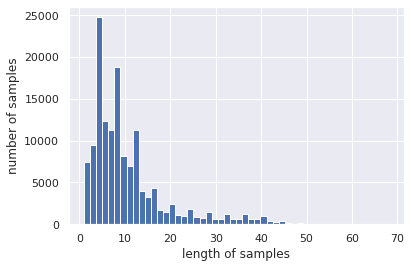

In [88]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show();

In [90]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [91]:
# max_len = 30이 적당할 것 같습니다. 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.52189498497096


In [92]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [93]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [94]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=777)

In [95]:
# 패키지 준비

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [96]:
# 모델 설계

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [97]:
# 모델 검증

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('new_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [98]:
# 모델 훈련

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [99]:
history = model.fit(X_train, y_train, epochs=20, batch_size=60, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
1912/1912 [==============================] - 45s 6ms/step - loss: 0.3896 - acc: 0.8236 - val_loss: 0.3644 - val_acc: 0.8377

Epoch 00001: val_acc improved from -inf to 0.83772, saving model to new_best_model.h5
Epoch 2/20
1912/1912 [==============================] - 11s 6ms/step - loss: 0.3275 - acc: 0.8570 - val_loss: 0.3399 - val_acc: 0.8537

Epoch 00002: val_acc improved from 0.83772 to 0.85369, saving model to new_best_model.h5
Epoch 3/20
1912/1912 [==============================] - 11s 6ms/step - loss: 0.3020 - acc: 0.8725 - val_loss: 0.3332 - val_acc: 0.8570

Epoch 00003: val_acc improved from 0.85369 to 0.85700, saving model to new_best_model.h5
Epoch 4/20
1912/1912 [==============================] - 11s 6ms/step - loss: 0.2837 - acc: 0.8817 - val_loss: 0.3264 - val_acc: 0.8588

Epoch 00004: val_acc improved from 0.85700 to 0.85878, saving model to new_best_model.h5
Epoch 5/20
1912/1912 [==============================] - 11s 6ms/step - loss: 0.2678 - acc: 0.8903 - val

In [100]:
# 테스트 정확도 측정

loaded_model = load_model('new_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1513/1513 [==============================] - 4s 3ms/step - loss: 0.3357 - acc: 0.8560

 테스트 정확도: 0.8560


- 좋은 전처리 만으로도 성능이 많이 향상되었다

### word2vec embedding

In [120]:
text = tokenizer.sequences_to_texts(X_train)

In [121]:
text

['좋다 좋다 ㅋㅋㅋㅋ',
 '최고다 처음 부터 끝 까지 지루함 없이 몰입 있다 후반 부로 갈수록 더 재밌다',
 '경찰 오토바이 타다 이민기 쫓다 신다 아일랜드 따르다',
 '이영화 망하다 이유 어처구니없다 스토리 아니다 발연기 때문 이다',
 '최고다 너무 재밌다 ㅎ',
 '수면제 같다 영화 같다 구 ㅠㅠㅠㅠ 평점 거짓 이다',
 '좋다 소재 가지 고 정도 밖에 못 뽑다 끝 까지 무슨 내용 인지 알다 없다 영화',
 '황 일화 님 주연 이고 화려하다 지난날 잊다 않다 온갖 오래되다 익숙하다 분 얼굴 내미다 ㅎㅎ 그러나 영화 지루하다',
 '장고 비 매력 적 인 캐릭터 없다 뿐더러 지루하다',
 '지루함 극 달린다',
 '여기 서 뭐',
 '진짜 제국 부활 보고 오다 전작 비교 안되다 제라드 버틀러 랑 잭 스나이더 감독 그립다 한마디 남다 오다',
 '우리나라 이렇다 영화',
 '댓글 아깝다',
 '술 먹다 보다 재미있다 모르다 맨 정신 끝 까지 보기 엔 무리 많다',
 '감동 먹다 보다 울다 ㅠㅠ 맨 끝 부분 에여',
 '어차피 팬 위 극장판 이니까 팬 으로서 부족하다 것 없다',
 '뭔가 알다 없다 매력 빠져들다 영화',
 '재미 없다 감동 없다 ㅇ 여주 완전 별로',
 '일어나다 오랜 만 다시 보다 영화 처음 볼 땐 아가씨 이다 나다 이제 엄마 되어다 있다 젖 몸살 자꾸 열 나다 아프다 옷 제대로 못 엄마 되다 뭘 끄다 생각',
 '전편 졸작 이라 나아지다 이병헌 아깝다 영화',
 '시간 아깝다 쩝 대사도 거의 없다',
 '영화 보고 난 후 심정은 아이 스스로 어른 되어다 느끼다 때 사랑 쌍 방향성 가지다 수 밖에 없다 라는 리뷰 어 님 말씀 충분하다 생각 오늘 엄마 에게 사랑 말씀드리다',
 '아 기대다 다운 받다 꿀잼 ㅎㅎ 공감 두 되다 ㅎㅎ 내 돈 아깝다 않다 ㅋㅋ 극장 에서 볼껄 ㅜㅜ',
 '년대 년 전 쯤 나오다 그나마 흥행 차다 영화 만들다 나름 열심히 찍다 만들다 이렇게 보다 사람 반응 거의 안좋다 건 예 상도 못 이다 과연',
 '자랑 질

In [123]:
vocab_size = 10000
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if text[i] in word_vectors.wv.key_to_index:
        embedding_matrix[i] = word_vectors.wv[text[i]]

In [124]:
# 모델 설계

model = Sequential()
# model.add(Embedding(vocab_size, 100))
model.add(Embedding(vocab_size, word_vector_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [125]:
# 모델 검증

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('new_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [126]:
# 모델 훈련

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [127]:
history = model.fit(X_train, y_train, epochs=20, batch_size=60, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
1912/1912 [==============================] - 13s 6ms/step - loss: 0.4555 - acc: 0.7765 - val_loss: 0.3808 - val_acc: 0.8288

Epoch 00001: val_acc improved from -inf to 0.82875, saving model to new_best_model.h5
Epoch 2/20
1912/1912 [==============================] - 11s 5ms/step - loss: 0.3589 - acc: 0.8400 - val_loss: 0.3639 - val_acc: 0.8376

Epoch 00002: val_acc improved from 0.82875 to 0.83758, saving model to new_best_model.h5
Epoch 3/20
1912/1912 [==============================] - 11s 6ms/step - loss: 0.3338 - acc: 0.8534 - val_loss: 0.3471 - val_acc: 0.8474

Epoch 00003: val_acc improved from 0.83758 to 0.84741, saving model to new_best_model.h5
Epoch 4/20
1912/1912 [==============================] - 11s 6ms/step - loss: 0.3179 - acc: 0.8631 - val_loss: 0.3389 - val_acc: 0.8502

Epoch 00004: val_acc improved from 0.84741 to 0.85020, saving model to new_best_model.h5
Epoch 5/20
1912/1912 [==============================] - 11s 6ms/step - loss: 0.3046 - acc: 0.8698 - val

In [128]:
# 테스트 정확도 측정

loaded_model = load_model('new_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1513/1513 [==============================] - 4s 2ms/step - loss: 0.3422 - acc: 0.8531

 테스트 정확도: 0.8531


## 회고

__배운점__
- Embedding이 성능향상을 내는 것을 볼 수 있었다 (CNN).
    - 안정적인 학습이 가능해지는 것을 확인하였다
    - 하지만 lstm 모델에서는 성능이 향상이 되지 않았다


__아쉬운점__
- tokenizer 별로 성능 정리를 해보고 싶었는데 시간상의 이유로 하지 못해서 아쉽다
- overfitting 문제가 많이 발생해서 이를 해결하기 위한 시도를 좀 더 해보고 싶다
